# Import libraries and load dataset

In [226]:
# Import required libraries
import pandas as pd
import numpy as np

# Load the original thyroid dataset
df = pd.read_csv("../data/thyroidDF.csv")

# Display dataset dimensions
df.shape

(9172, 31)

# Drop ID &TBG & TBG_measured

In [227]:
# Drop TBG because it contains more than 90% missing values
# Such a high missing rate makes the feature unreliable

df = df.drop(columns=["TBG"], errors="ignore")

# Drop id we don't need it 
df = df.drop(columns=["patient_id"], errors="ignore")

# Drop TBG_measured
df = df.drop(columns=["TBG_measured"], errors="ignore")

# Drop referral_source
df = df.drop(columns=["referral_source"], errors="ignore")


# Remove unrealistic age values (medical plausibility check)

In [228]:
# Remove medically implausible age values
# Only keep ages between 0 and 100 years

df = df[(df["age"].notna()) & (df["age"] >= 0) & (df["age"] <= 100)].copy()

df.shape

(9168, 27)

# Encode Categorical Variables

In [229]:
# Binary encoding (t/f → 1/0)
tf_cols = df.columns[df.isin(['t', 'f']).any()]
for c in tf_cols:
    df[c] = df[c].map({'t': 1, 'f': 0})

# Sex encoding (M/F → 1/0)
df['sex'] = df['sex'].map({'M': 1, 'F': 0})


# Clinical Consistency Logic (BEFORE Imputation)

In [230]:
# If lab test was NOT measured (flag=0), set value to NaN
lab_pairs = [
    ("TSH", "TSH_measured"),
    ("T3", "T3_measured"),
    ("TT4", "TT4_measured"),
    ("T4U", "T4U_measured"),
    ("FTI", "FTI_measured"),
]

for lab, flag in lab_pairs:
    if lab in df.columns and flag in df.columns:
        df.loc[df[flag] == 0, lab] = np.nan


# Handle Missing Values (Imputation)

In [231]:
# Mode for categorical
if 'sex' in df.columns:
    df['sex'] = df['sex'].fillna(df['sex'].mode()[0])
if 'referral_source' in df.columns:
    df['referral_source'] = df['referral_source'].fillna(df['referral_source'].mode()[0])

# Median for numerical lab values
labs = ['TSH', 'T3', 'TT4', 'T4U', 'FTI']
for lab in labs:
    if lab in df.columns:
        df[lab] = df[lab].fillna(df[lab].median())


# Create hyperthyroidism label (Medical Rule-Based Definition)

In [232]:


# Clinical thresholds for hyperthyroidism diagnosis
TSH_LOW = 0.4    # TSH below 0.4 indicates potential hyperthyroidism
T3_HIGH = 2.0    # T3 above 2.0 is elevated
FTI_HIGH = 120   # FTI above 120 is elevated

# Apply clinical rules on UNSCALED data
low_tsh = df['TSH'] < TSH_LOW
high_t3 = df['T3'] > T3_HIGH
high_fti = df['FTI'] > FTI_HIGH

# Classification:
# - Overt Hyperthyroidism (2): Low TSH + (High T3 OR High FTI)
# - Subclinical Hyperthyroidism (1): Low TSH + Normal T3 + Normal FTI
# - Normal (0): Everything else

overt = low_tsh & (high_t3 | high_fti)
subclinical = low_tsh & (~high_t3) & (~high_fti)

df['hyperlabel'] = np.select(
    [overt, subclinical], 
    [2, 1], 
    default=0
)

# Display distribution
print("\n✅ Hyperlabel created!")
print("\nDistribution:")
hyperlabel_counts = df['hyperlabel'].value_counts().sort_index()
print(hyperlabel_counts)

print("\nBreakdown:")
print(f"  0 (Normal):         {(df['hyperlabel']==0).sum():>5} patients")
print(f"  1 (Subclinical):    {(df['hyperlabel']==1).sum():>5} patients")
print(f"  2 (Overt Hyper):    {(df['hyperlabel']==2).sum():>5} patients")

# Verify column exists
print(f"\n✅ 'hyperlabel' column added to dataset")
print(f"Current shape: {df.shape}")


✅ Hyperlabel created!

Distribution:
hyperlabel
0    7267
1     502
2    1399
Name: count, dtype: int64

Breakdown:
  0 (Normal):          7267 patients
  1 (Subclinical):      502 patients
  2 (Overt Hyper):     1399 patients

✅ 'hyperlabel' column added to dataset
Current shape: (9168, 28)


# Check for duplicates

In [233]:
# Check for duplicates
print("Number of duplicates:", df.duplicated().sum())
print("Shape before removal:", df.shape)

# Remove duplicates (keep first occurrence)
previous_shape = df.shape
df = df.drop_duplicates()
print("Shape after removal:", df.shape)
print("Duplicates removed:", previous_shape[0] - df.shape[0])


Number of duplicates: 108
Shape before removal: (9168, 28)
Shape after removal: (9060, 28)
Duplicates removed: 108


# Normalisation / standardisation

In [234]:
from sklearn.preprocessing import StandardScaler

numerical_cols = ['age', 'TSH', 'T3', 'TT4', 'T4U', 'FTI']
scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

print("✅ Standardization complete!")
print(df[numerical_cols].describe())


✅ Standardization complete!
                age           TSH            T3           TT4           T4U  \
count  9.060000e+03  9.060000e+03  9.060000e+03  9.060000e+03  9.060000e+03   
mean  -4.705581e-17 -1.764593e-17 -1.521471e-16 -1.552842e-16 -7.089742e-16   
std    1.000055e+00  1.000055e+00  1.000055e+00  1.000055e+00  1.000055e+00   
min   -2.706520e+00 -2.113703e-01 -2.513750e+00 -2.891642e+00 -4.180509e+00   
25%   -8.034531e-01 -1.874593e-01 -3.319594e-01 -5.571579e-01 -5.443884e-01   
50%    1.480805e-01 -1.512696e-01 -6.749992e-02 -1.228353e-01 -7.688715e-02   
75%    8.352993e-01 -9.957017e-02  3.291893e-01  4.472131e-01  3.906141e-01   
max    2.368326e+00  2.262235e+01  2.122149e+01  1.334116e+01  7.039521e+00   

                FTI  
count  9.060000e+03  
mean  -5.489845e-18  
std    1.000055e+00  
min   -2.800559e+00  
25%   -4.576883e-01  
50%   -1.072590e-01  
75%    3.182623e-01  
max    1.921641e+01  


#  Corrélations

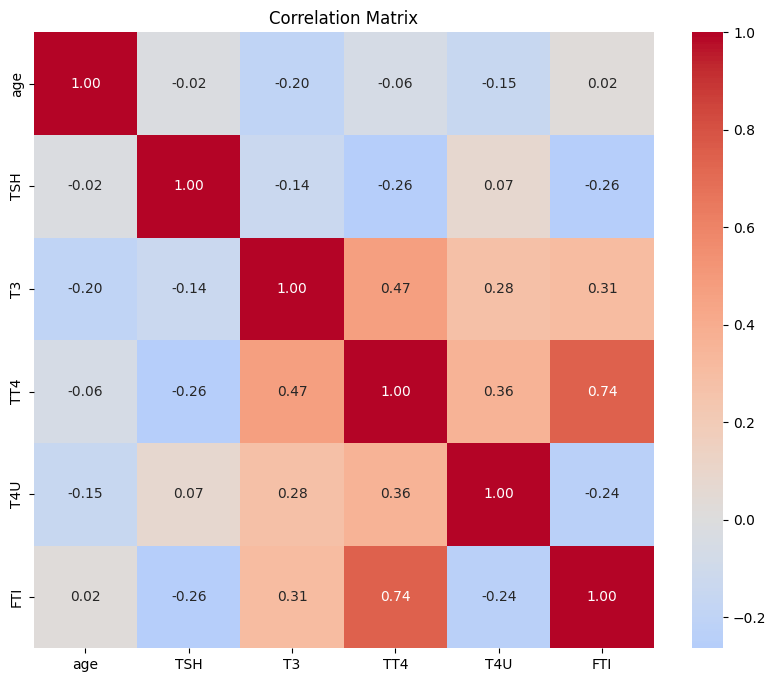

In [235]:
import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix = df[numerical_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

# Find high correlations (>0.9)
high_corr = np.where(np.abs(corr_matrix) > 0.9)
# (check for redundant features)


# preprocessed data

In [236]:
df.to_csv('../data/preprocessed_data.csv', index=False)
print("✅ preprocessed_data saved successfully!")

✅ preprocessed_data saved successfully!


# Final Checklist

In [237]:
import pandas as pd
import numpy as np

# Load your preprocessed data
df = pd.read_csv('../data/preprocessed_data.csv')




# If hyperlabel is missing, we need to create it
if 'hyperlabel' not in df.columns:
    print("\n⚠️ HYPERLABEL IS MISSING!")
    print("\n🔧 Option 1: Re-run your preprocessing notebook WITH hyperlabel step")
    print("🔧 Option 2: Add it now (but TSH/T3/FTI are scaled, so we need original values)")
    
    # Check if you have another file with hyperlabel
    print("\n💡 Do you have these files?")
    import os
    files = ['../data/thyroid_cleaned_step2.csv', 
             '../data/thyroid_scaled.csv',
             '../data/thyroidDF.csv']
    
    for f in files:
        if os.path.exists(f):
            temp = pd.read_csv(f)
            has_hyper = 'hyperlabel' in temp.columns
            print(f"   {f}: EXISTS - hyperlabel={has_hyper}")
        else:
            print(f"   {f}: NOT FOUND")
    
    print("\n📌 RECOMMENDED: Go back to your preprocessing notebook")
    print("   Make sure to include the hyperlabel creation step BEFORE saving!")
    
else:
    
    
    # Continue with all checks
    print("\n" + "="*60)
    print("FINAL DATA QUALITY CHECK")
    print("="*60)
    
    print(f"\n✅ 1. Dataset Shape: {df.shape}")
    
    print(f"\n✅ 2. Missing Values: {df.isnull().sum().sum()}")
    
    print(f"\n✅ 3. Duplicates: {df.duplicated().sum()}")
    
    numerical_cols = ['age', 'TSH', 'T3', 'TT4', 'T4U', 'FTI']
    print(f"\n✅ 4. Standardization Check:")
    print(df[numerical_cols].describe().loc[['mean', 'std']])
    
    print(f"\n✅ 5. Hyperlabel Distribution:")
    print(df['hyperlabel'].value_counts().sort_index())
    
    print("\n" + "="*60)
    print("✅ ALL CHECKS PASSED! Ready to save as final!")
    print("="*60)



FINAL DATA QUALITY CHECK

✅ 1. Dataset Shape: (9060, 28)

✅ 2. Missing Values: 0

✅ 3. Duplicates: 0

✅ 4. Standardization Check:
               age           TSH            T3           TT4           T4U  \
mean -3.764465e-17  1.646953e-17 -1.552842e-16 -1.490101e-16 -7.121113e-16   
std   1.000055e+00  1.000055e+00  1.000055e+00  1.000055e+00  1.000055e+00   

               FTI  
mean -3.137054e-18  
std   1.000055e+00  

✅ 5. Hyperlabel Distribution:
hyperlabel
0    7160
1     502
2    1398
Name: count, dtype: int64

✅ ALL CHECKS PASSED! Ready to save as final!


# Save Final Dataset

In [238]:
import pandas as pd

# Load the data
df = pd.read_csv('../data/preprocessed_data.csv')

# Save as final dataset
df.to_csv('../data/thyroid_final.csv', index=False)

print("✅ Final dataset saved successfully!")
print(f"📁 Location: ../data/thyroid_final.csv")
print(f"📊 Shape: {df.shape}")
print("\n🎉 Preprocessing Complete!")
print("Ready for Step 3: EDA and Step 4: ML Modeling")

✅ Final dataset saved successfully!
📁 Location: ../data/thyroid_final.csv
📊 Shape: (9060, 28)

🎉 Preprocessing Complete!
Ready for Step 3: EDA and Step 4: ML Modeling
